In [26]:
import importlib
import segment
importlib.reload(segment)
from segment import load_report_with_images, get_docs_with_ocr
from doctr.models import ocr_predictor
import os
import pickle

CACHE_PATH = "../data/cache/ocr_docs3.pkl"

if os.path.exists(CACHE_PATH):
    print("Loading docs from cache...")
    with open(CACHE_PATH, "rb") as f:
        docs = pickle.load(f)
    print("Loaded from cache:", len(docs))
else:
    ocr_model = ocr_predictor(det_arch='db_resnet50', reco_arch='crnn_vgg16_bn', pretrained=True).cuda()
    items = load_report_with_images(limit=1000)
    print("Loaded:", len(items))
    docs = get_docs_with_ocr(items, ocr_model)
    print("Parsed:", len(docs))
    os.makedirs(os.path.dirname(CACHE_PATH), exist_ok=True)
    with open(CACHE_PATH, "wb") as f:
        pickle.dump(docs, f)
    print("Saved docs to cache:", CACHE_PATH)

docs = [doc for doc in docs if len(doc['segments']) < 120]

Loading docs from cache...
Loaded from cache: 1000


In [3]:
from datasets import Dataset
from transformers import LayoutLMv3Processor, LayoutLMv3ForTokenClassification
from PIL import Image, ImageDraw, ImageFont
import torch
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from torch.utils.data import DataLoader


processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

# we need to define custom features
# features = Features({
#     'image': Array3D(dtype="int64", shape=(3, 224, 224)),
#     'input_ids': Sequence(feature=Value(dtype='int64')),
#     'attention_mask': Sequence(Value(dtype='int64')),
#     'token_type_ids': Sequence(Value(dtype='int64')),
#     'bbox': Array2D(dtype="int64", shape=(512, 4)),
#     'labels': Sequence(ClassLabel(names=labels)),
# })

def normalize_doc(d):
    h, w = d['dimensions']
    for box in d['boxes']:
        box[0] = int(box[0] / w * 1000)
        box[1] = int(box[1] / h * 1000)
        box[2] = int(box[2] / w * 1000)
        box[3] = int(box[3] / h * 1000)
    return {
        "words": d["words"],          # list of strings
        "boxes": d["boxes"],
        "labels": d["labels"],        # list of ints
        "image_path": d["image_path"]
    }


def preprocess_data(examples):
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]
  words = examples['words']
  boxes = examples['boxes']
  word_labels = examples['labels']
  
  encoded_inputs = processor(images, words, boxes=boxes, word_labels=word_labels,
                             padding="max_length", truncation=True)
  
  return encoded_inputs

rows = [normalize_doc(d) for d in docs]
ds = Dataset.from_list(rows)
ds = ds.train_test_split(test_size=0.1, seed=42)
train_dataset = ds['train'].map(preprocess_data, batched=True, remove_columns=ds['train'].column_names)
test_dataset = ds['test'].map(preprocess_data, batched=True, remove_columns=ds['test'].column_names)

train_dataset.set_format(type="torch")
test_dataset.set_format(type="torch")

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [12]:
import torch
import torch.nn as nn
from transformers import LayoutLMv3Model, LayoutLMv3Config

class LayoutLMv3Seq2SeqSegmenter(nn.Module):
    def __init__(self, encoder_name="microsoft/layoutlmv3-base",
                 num_labels=128, decoder_layers=4):
        super().__init__()

        # 1. Encoder (pretrained)
        self.encoder = LayoutLMv3Model.from_pretrained(encoder_name)

        hidden_dim = self.encoder.config.hidden_size

        # 2. Decoder token embeddings (for label tokens)
        self.label_emb = nn.Embedding(num_labels, hidden_dim)

        # 3. Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_dim,
            nhead=8,
            batch_first=True,
        )
        self.decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=decoder_layers
        )

        # 4. Output head: hidden → label logits
        self.out_proj = nn.Linear(hidden_dim, num_labels)

    def forward(self, input_ids, bbox, pixel_values,
                attention_mask, labels=None):
        """
        labels: (batch, tgt_len) — class IDs for segments
        """

        # -----------------------
        # 1. Encoder forward
        # -----------------------
        enc_out = self.encoder(
            input_ids=input_ids,
            bbox=bbox,
            attention_mask=attention_mask,
            output_hidden_states=False
        ).last_hidden_state
        # enc_out shape = [B, src_len, hidden]

        # -----------------------
        # 2. Decoder
        # -----------------------
        if labels is None:
            # inference mode
            return enc_out

        # Autoregressive mask (triangular)
        B, T = labels.shape
        tgt_mask = torch.triu(
            torch.ones(T, T, device=labels.device) * float('-inf'),
            diagonal=1
        )

        # label embeddings
        tgt_embed = self.label_emb(labels)  # [B, T, H]

        dec_out = self.decoder(
            tgt=tgt_embed,
            memory=enc_out,
            tgt_mask=tgt_mask
        )  # [B, T, H]

        # -----------------------
        # 3. Output logits
        # -----------------------
        logits = self.out_proj(dec_out)  # [B, T, num_labels]

        return logits

criterion = nn.CrossEntropyLoss(ignore_index=-100)
model = LayoutLMv3Seq2SeqSegmenter()


for batch in train_dataloader:
    input_ids = batch["input_ids"]
    bbox = batch["bbox"]
    pixel_values = batch["pixel_values"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    logits = model(
        input_ids=input_ids,
        bbox=bbox,
        pixel_values=pixel_values,
        attention_mask=attention_mask,
        labels=labels
    )

    loss = criterion(
        logits.view(-1, num_labels),
        labels.view(-1)
    )

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

/home/compiling-ganesh/24m0797/workspace/doctr-dit/.venv/lib/python3.13/site-packages/transformers/modeling_utils.py:1621: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


IndexError: index out of range in self

In [25]:
from collections import Counter

counter = Counter()


for doc in docs:
    counter.update(doc["labels"])


print(len(docs))

995


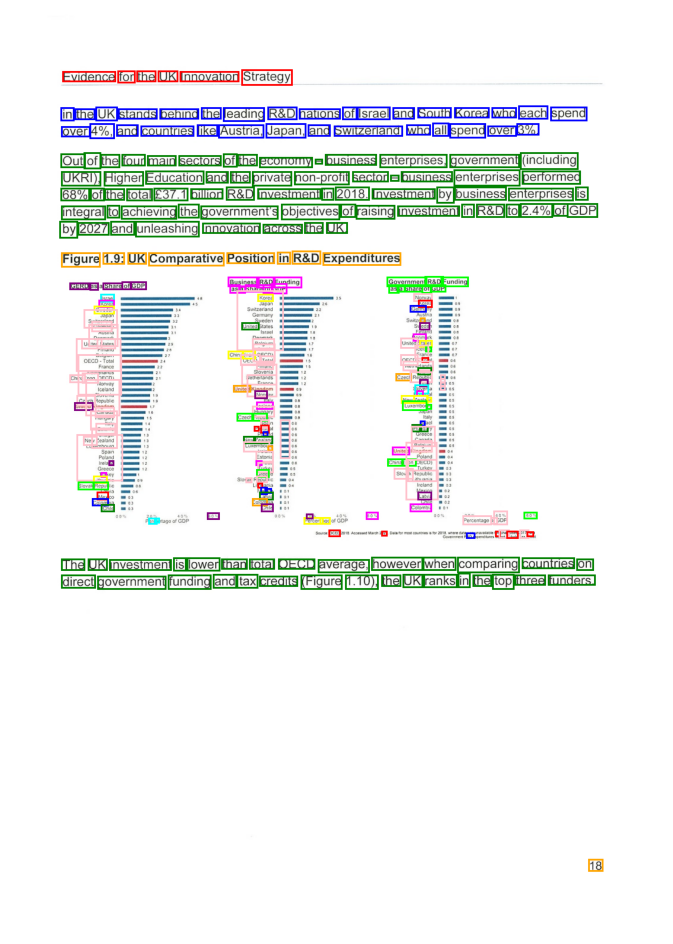

In [19]:
for doc in docs:
    if 191 in doc['labels']:
        # print(doc)
        break

img = visualize_word_boxes(doc["image_path"], doc["boxes"], doc["labels"])
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis("off")
plt.show()

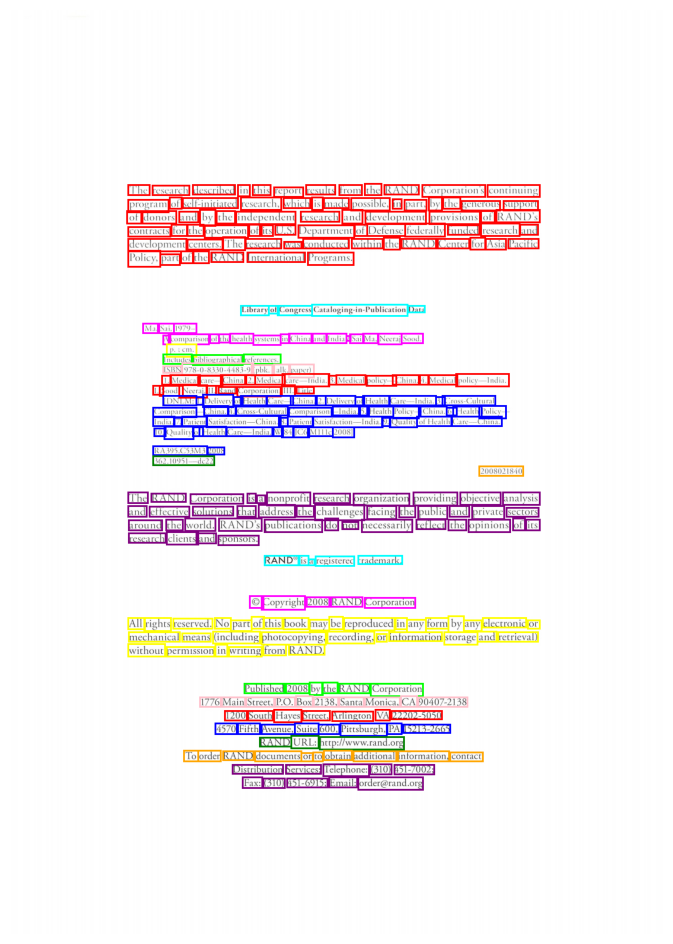

In [8]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import importlib
# import visualize
# importlib.reload(visualize)
from visualize import visualize_word_boxes

data = docs[90]
img = visualize_word_boxes(data["image_path"], data["boxes"], data["labels"])
plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis("off")
plt.show()